In [162]:
from keras import backend as K

def squash(x, axis=-1):
    s_squared_norm = K.sum(K.square(x), axis, keepdims=True) + K.epsilon()
    scale = K.sqrt(s_squared_norm)/ (0.5 + s_squared_norm)
    return scale * x

def softmax(x, axis=-1):
    ex = K.exp(x - K.max(x, axis=axis, keepdims=True))
    return ex/K.sum(ex, axis=axis, keepdims=True)
 

In [163]:
from keras import utils
from keras.datasets import mnist
from keras.models import Model
from keras.layers import *
from keras import backend as K
import numpy as np

In [164]:
#Prepare training data
batch_size = 32
num_classes = 10
img_rows, img_cols = 28, 28


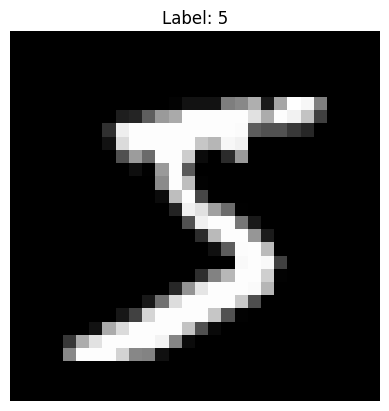

In [165]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()#Import data
y_test_p =y_test#Keep labels for calculating accuracy

import matplotlib.pyplot as plt
## Display the image of the first number
plt.imshow(x_train[0], cmap='gray')
plt.title(f"Label: {y_train[0]}")
plt.axis('off')
plt.show()

In [166]:
#Data preprocessing
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
#Convert to one-hot format
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)


In [167]:
#Reorder the test set and concatenate it with the original test set, creating a new test set with each image containing two different numbers.
idx = list(range(len(x_test)))
np.random.shuffle(idx)
X_test = np.concatenate([x_test, x_test[idx]], 1)
Y_test = np.vstack([y_test.argmax(1), y_test[idx].argmax(1)]).T
X_test = X_test[Y_test[:, 0] != Y_test[:, 1]]
Y_test = Y_test[Y_test[:, 0] != Y_test[:, 1]]
Y_test.sort(axis=1)

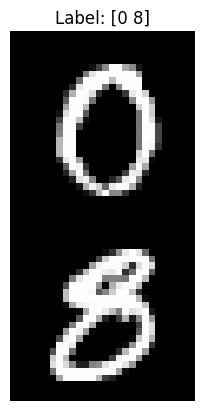

In [168]:
#Display the image of the eleventh set of numbers
plt.imshow(X_test[11], cmap='gray')
plt.title(f"Label: {Y_test[11]}")
plt.axis('off')

plt.show()

In [169]:
#Customize the construction of a CNN model
input_image = Input(shape=(28,28,1))
cnn = Conv2D(64, (3, 3), activation='relu')(input_image)
cnn = Conv2D(64, (3, 3), activation='relu')(cnn)
cnn = AveragePooling2D((2,2))(cnn)
cnn = Conv2D(128, (3, 3), activation='relu')(cnn)
cnn = Conv2D(128, (3, 3), activation='relu')(cnn)
cnn = GlobalAveragePooling2D()(cnn)
dense = Dense(128, activation='relu')(cnn)
output = Dense(10, activation='sigmoid')(dense)

model = Model(inputs=input_image, outputs=output)
model.compile(loss=lambda y_true,y_pred: y_true*K.relu(0.9-y_pred)**2 + 0.25*(1-y_true)*K.relu(y_pred-0.1)**2,
              optimizer='adam',
              metrics=['accuracy'])
 
model.summary()

Model: "functional_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_118 (Conv2D)          (None, 26, 26, 64)        640       
_________________________________________________________________
conv2d_119 (Conv2D)          (None, 24, 24, 64)        36928     
_________________________________________________________________
average_pooling2d_18 (Averag (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_120 (Conv2D)          (None, 10, 10, 128)       73856     
_________________________________________________________________
conv2d_121 (Conv2D)          (None, 8, 8, 128)         147584    
_________________________________________________________________
global_average_pooling2d_16  (None, 128)             

In [170]:
#Train the model
history=model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=10,
          verbose=1,
          validation_data=(x_test,y_test)
          )

Epoch 1/10
1875/1875 [==============================] - 111s 59ms/step - loss: 0.0066 - accuracy: 0.8905 - val_loss: 0.0019 - val_accuracy: 0.9704
Epoch 2/10
1875/1875 [==============================] - 110s 58ms/step - loss: 0.0013 - accuracy: 0.9800 - val_loss: 9.3795e-04 - val_accuracy: 0.9864
Epoch 3/10
1875/1875 [==============================] - 110s 59ms/step - loss: 8.4282e-04 - accuracy: 0.9866 - val_loss: 7.9888e-04 - val_accuracy: 0.9861
Epoch 4/10
1875/1875 [==============================] - 109s 58ms/step - loss: 6.5917e-04 - accuracy: 0.9892 - val_loss: 6.1927e-04 - val_accuracy: 0.9886
Epoch 5/10
1875/1875 [==============================] - 109s 58ms/step - loss: 5.3936e-04 - accuracy: 0.9913 - val_loss: 5.5495e-04 - val_accuracy: 0.9904
Epoch 6/10
1875/1875 [==============================] - 109s 58ms/step - loss: 4.5137e-04 - accuracy: 0.9929 - val_loss: 4.8742e-04 - val_accuracy: 0.9920
Epoch 7/10
1875/1875 [==============================] - 110s 59ms/step - loss: 3.9

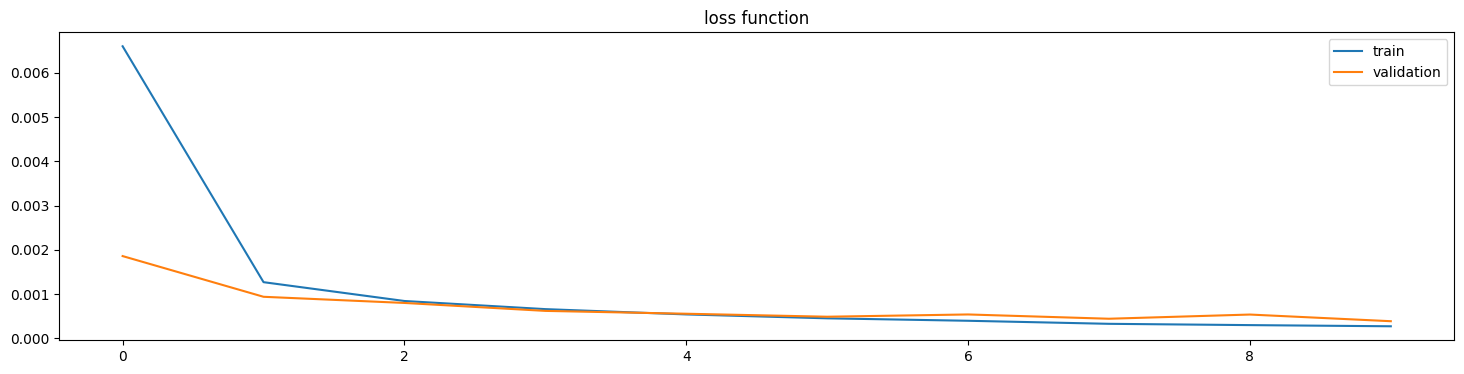

In [171]:
# plot loss with epochs
plt.figure(figsize=(18,4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.title('loss function')
plt.show()

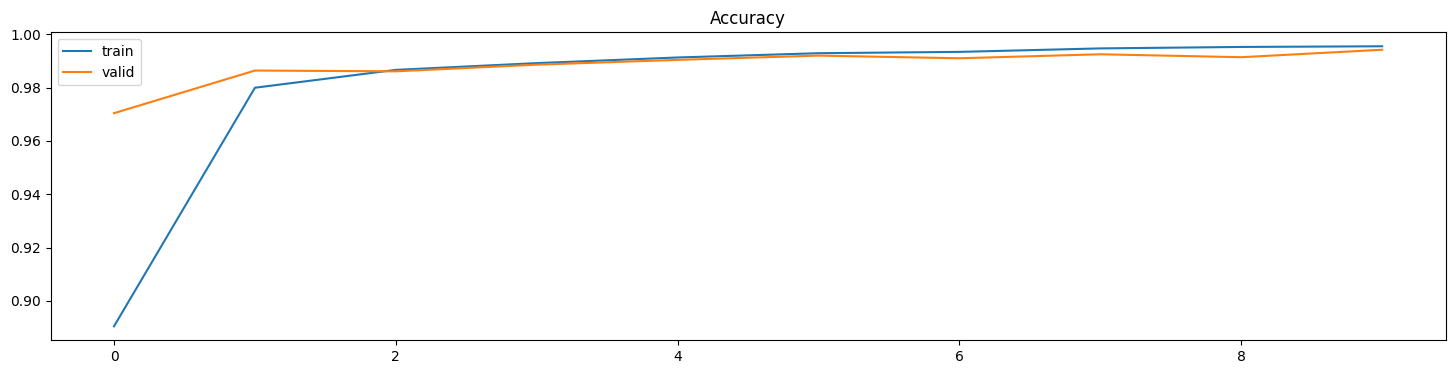

In [172]:
# Plot accuracy through epochs
plt.figure(figsize=(18, 4))
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'valid')
plt.legend()
plt.title('Accuracy')
plt.show()

In [182]:
#Calculate the model accuracy using the original test set
Y_pred = model.predict(x_test)
Y_pred = Y_pred.argsort()[:,-1:] #Retrieve the class with the highest score" 或 "Select the class with the highest score
Y_pred = Y_pred.reshape(-1)
accurate_predictions = np.equal(Y_pred, y_test_p)
acc = np.mean(accurate_predictions)
print (u'CNN+Pooling accuracy：%s'%acc)

CNN+Pooling accuracy：0.9942


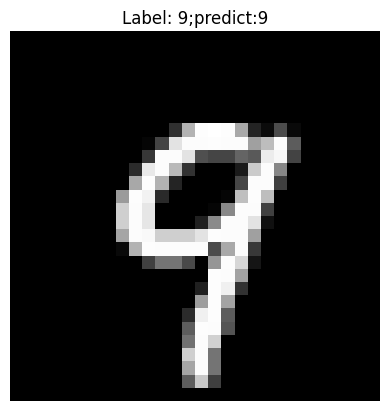

In [174]:
#Choose a number to check the recognition status
plt.imshow(x_test[12], cmap='gray')
plt.title(f"Label: {y_test_p[12]};predict:{Y_pred[12]}")
plt.axis('off')
plt.show()

In [183]:
#Calculate the model accuracy using the new test set
Y_pred = model.predict(X_test)
Y_pred = Y_pred.argsort()[:,-2:] #Choose the two classes with the highest scores
Y_pred.sort(axis=1) 
acc = 1.*(np.prod(Y_pred == Y_test, axis=1)).sum()/len(X_test)
print (u'CNN+Pooling accuracy：%s'%acc)


CNN+Pooling accuracy：0.45546761787983503


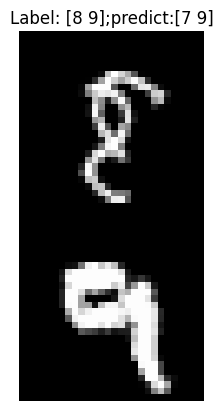

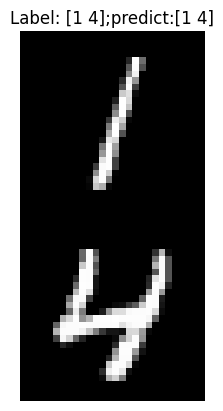

In [180]:
#Choose two sets of data to examine the recognition performance
plt.imshow(X_test[1001], cmap='gray')
plt.title(f"Label: {Y_test[1001]};predict:{Y_pred[1001]}")
plt.axis('off')
plt.show()

plt.imshow(X_test[2], cmap='gray')
plt.title(f"Label: {Y_test[2]};predict:{Y_pred[2]}")
plt.axis('off')
plt.show()